In [1]:
# Basic
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import cycle

# Avoid warning messages
import warnings
warnings.filterwarnings("ignore")

# Scikit-learn
from sklearn.metrics import confusion_matrix, confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Scipy
from scipy import interp

# Keras & Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from keras.constraints import maxnorm

In [2]:
# Locate data directory
filepath = r'drug200.csv'

df = pd.read_csv(filepath)

## Data exploratory

In [3]:
df.head(10)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
5,22,F,NORMAL,HIGH,8.607,drugX
6,49,F,NORMAL,HIGH,16.275,DrugY
7,41,M,LOW,HIGH,11.037,drugC
8,60,M,NORMAL,HIGH,15.171,DrugY
9,43,M,LOW,NORMAL,19.368,DrugY


In [4]:
df.shape

(200, 6)

In [5]:
df.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


## Train Test Split

In [6]:
# X - features, y - target
X = df.drop(["Drug"],axis=1)
y = df.Drug

# Dummify categorized variable
X = pd.get_dummies(X, ['Sex','BP','Cholesterol'])
y = pd.get_dummies(y, ['Drug'])

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2, 3, 4])
n_classes = y.shape[1]

In [7]:
# Split the data to Train, and Test (80%, 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

## Inverse transform dummy variable

In [8]:
# Transform the target variable from [0,0,1,0,0] back to [2]
def inverse_transform(array):
    list = []
    for rows in range(array.shape[0]):
        for cols in range(array.shape[1]):
            if (array[rows,cols] == 1):
                list.append(cols)
    return list

## Normalization

In [9]:
# Scale data with mean=0 and standard deviation=1
normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

## Timer

In [10]:
# Count training model runtime
def tic():
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time, math;
    if 'startTime_for_tictoc' in globals():
        dt = math.floor(100*(time.time() - startTime_for_tictoc))/100.;
        #print('Elapsed time is {} second(s).'.format(dt));
        return dt
    else:
        print('Start time not set. You should call tic before toc.');

## Plot ROC Curve

In [11]:
# Plot ROC Curve for multiclass classification
def plot_multiple_roc(y_test, y_pred, model_name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.3f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', lw=2)

    ax.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.3f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', lw=2)

    colors = cycle(['aqua','c','m','y','k'])
    for i, color in zip(range(n_classes), colors):
        ax.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.3f})'
                 ''.format(i, roc_auc[i]))

    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve to multi-class')
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])
    ax.grid(True)
    ax.legend()

## Neural Network (NN)

In [12]:
model_NN = Sequential([Dense(30, input_dim=X_train_norm.shape[1], activation='relu'),
                       Dropout(0.2),
                       Dense(30, activation='relu', kernel_constraint=maxnorm(3)),
                       Dropout(0.2),
                       Dense(5, activation='softmax', kernel_constraint=maxnorm(3))
                      ])
model_NN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                300       
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 155       
Total params: 1,385
Trainable params: 1,385
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Compile the model with the following parameter
model_NN.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

# Early stop before overfitting
early_stop = EarlyStopping(monitor='val_loss',
                           mode='min',
                           patience=20,
                           restore_best_weights=True)

In [14]:
# Start Training
tic()
run_NN = model_NN.fit(x = X_train_norm, 
                      y = y_train,
                      validation_data = (X_test_norm, y_test),
                      epochs = 150,
                      batch_size = 20,
                      callbacks=[early_stop])
nn_time = toc()
# End

Epoch 1/150
8/8 [==============================] - 0s 14ms/step - loss: 1.6937 - accuracy: 0.1437 - val_loss: 1.6341 - val_accuracy: 0.0750
Epoch 2/150
8/8 [==============================] - 0s 2ms/step - loss: 1.5894 - accuracy: 0.2125 - val_loss: 1.5279 - val_accuracy: 0.2000
Epoch 3/150
8/8 [==============================] - 0s 2ms/step - loss: 1.5117 - accuracy: 0.3000 - val_loss: 1.4354 - val_accuracy: 0.4250
Epoch 4/150
8/8 [==============================] - 0s 2ms/step - loss: 1.4091 - accuracy: 0.3938 - val_loss: 1.3492 - val_accuracy: 0.5750
Epoch 5/150
8/8 [==============================] - 0s 2ms/step - loss: 1.3268 - accuracy: 0.5188 - val_loss: 1.2714 - val_accuracy: 0.6000
Epoch 6/150
8/8 [==============================] - 0s 3ms/step - loss: 1.2752 - accuracy: 0.5500 - val_loss: 1.1994 - val_accuracy: 0.6500
Epoch 7/150
8/8 [==============================] - 0s 2ms/step - loss: 1.2067 - accuracy: 0.5875 - val_loss: 1.1325 - val_accuracy: 0.6750
Epoch 8/150
8/8 [=========

8/8 [==============================] - 0s 2ms/step - loss: 0.2365 - accuracy: 0.9062 - val_loss: 0.1453 - val_accuracy: 0.9750
Epoch 60/150
8/8 [==============================] - 0s 2ms/step - loss: 0.1877 - accuracy: 0.9500 - val_loss: 0.1407 - val_accuracy: 0.9750
Epoch 61/150
8/8 [==============================] - 0s 2ms/step - loss: 0.2148 - accuracy: 0.9375 - val_loss: 0.1436 - val_accuracy: 0.9750
Epoch 62/150
8/8 [==============================] - 0s 2ms/step - loss: 0.2148 - accuracy: 0.9375 - val_loss: 0.1412 - val_accuracy: 0.9750
Epoch 63/150
8/8 [==============================] - 0s 2ms/step - loss: 0.2535 - accuracy: 0.9250 - val_loss: 0.1322 - val_accuracy: 0.9750
Epoch 64/150
8/8 [==============================] - 0s 2ms/step - loss: 0.2306 - accuracy: 0.9375 - val_loss: 0.1293 - val_accuracy: 0.9750
Epoch 65/150
8/8 [==============================] - 0s 2ms/step - loss: 0.1928 - accuracy: 0.9125 - val_loss: 0.1288 - val_accuracy: 0.9750
Epoch 66/150
8/8 [===============

In [15]:
# Probabilistic score
y_pred_nn = model_NN.predict(X_test_norm)

# Hard decision
y_pred_class_nn = np.argmax(y_pred_nn,axis=1)

## Confusion Matrix (NN)

In [16]:
nn_cm = confusion_matrix(inverse_transform(y_test), y_pred_class_nn)
nn_acc = (accuracy_score(inverse_transform(y_test), y_pred_class_nn))

print(nn_cm)
print("\nAccuracy: %.3f" % nn_acc)

[[18  0  0  1  0]
 [ 0  4  0  0  0]
 [ 0  0  4  0  0]
 [ 0  0  0  2  0]
 [ 0  0  0  0 11]]

Accuracy: 0.975


## ROC Curve (NN)

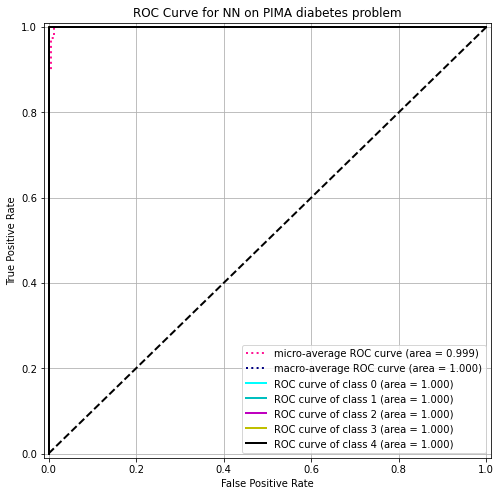

In [17]:
plot_multiple_roc(y_test, y_pred_nn, 'NN')

## Loss over iterations (NN)

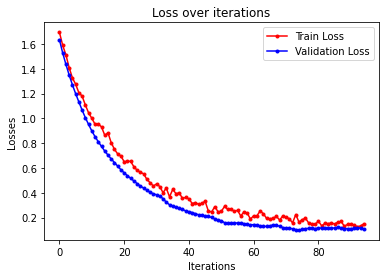

In [18]:
fig, ax = plt.subplots()
ax.plot(run_NN.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_NN.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.set_title("Loss over iterations")
ax.set_xlabel("Iterations")
ax.set_ylabel("Losses")
ax.legend()

## K-nearest neighbors (KNN)

In [19]:
knn = KNeighborsClassifier()
accuracies = cross_val_score(knn, X_train_norm, y_train, cv=5)
knn.fit(X_train_norm,y_train)

print("Train Score:", np.mean(accuracies))
print("Test Score:", knn.score(X_test_norm,y_test))

Train Score: 0.64375
Test Score: 0.775


## GridSearchCV (KNN)

Hyperparameters: {'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
Train Score: 0.8625
Test Score: 0.925
Maximum accuracy: 0.925 at K = 1


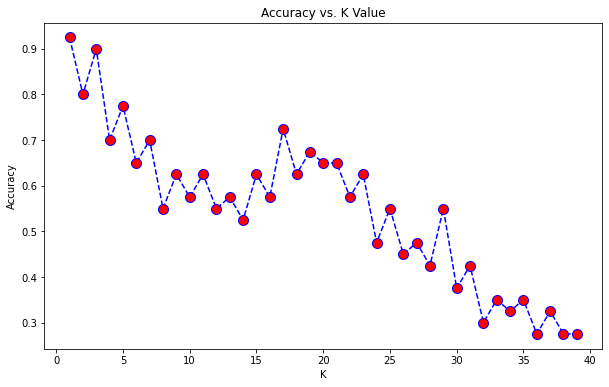

In [20]:
# Get predefined hyperparameters
grid = {'n_neighbors' : np.arange(1,120),
        'p' : np.arange(1,3),
        'weights' : ['uniform','distance']
       }

knn = KNeighborsClassifier(algorithm = "auto")
knn_cv = GridSearchCV(knn,grid,cv=5)
knn_cv.fit(X_train_norm,y_train)

print("Hyperparameters:", knn_cv.best_params_)
print("Train Score:", knn_cv.best_score_)
print("Test Score:", knn_cv.score(X_test_norm, y_test))

acc = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors = i).fit(X_train_norm,y_train)
    y_pred = knn.predict(X_test_norm)
    acc.append(accuracy_score(y_test, y_pred))
    
# Plot the K values for KNN model with its accuracy    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:",max(acc),"at K =",acc.index(max(acc))+1)

In [21]:
# Start Training
tic()
knn = KNeighborsClassifier(n_neighbors = acc.index(max(acc))+1,
                           p = 2,
                           weights='uniform')
knn.fit(X_train_norm,y_train)
knn_time = toc()
# End

y_pred_knn = knn.predict(X_test_norm)

## Confusion Matrix (KNN)

In [22]:
knn_cm = confusion_matrix(inverse_transform(y_test), inverse_transform(y_pred_knn))
knn_acc = (accuracy_score(y_test, y_pred_knn))

print(knn_cm)
print("\nAccuracy: %.3f" % knn_acc)

[[17  1  0  1  0]
 [ 0  4  0  0  0]
 [ 0  0  4  0  0]
 [ 0  0  0  2  0]
 [ 1  0  0  0 10]]

Accuracy: 0.925


## ROC Curve (KNN)

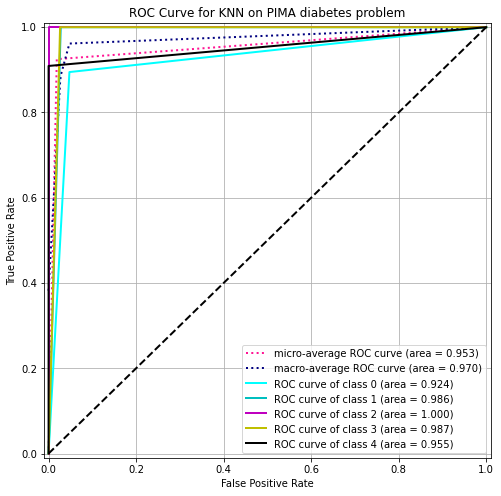

In [23]:
plot_multiple_roc(y_test, y_pred_knn, 'KNN')

## Gaussian Naive-Bayes Classification (GNB)

Assume features are continuous, and Gaussian Naive Bayes is used.

In [24]:
gnb = GaussianNB()
gnb_params = [{'var_smoothing': [10,1,0.1,0.01,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10]}]

# GridSearchCV to get the best hyperparameters for the model
gnb_cv = GridSearchCV(gnb, gnb_params, cv = 5, scoring='accuracy')

gnb_cv.fit(X_train_norm, inverse_transform(y_train))
print("The best parameter for GaussianNB() is", gnb_cv.best_params_)
print("with the accuracy train score at", gnb_cv.best_score_)

The best parameter for GaussianNB() is {'var_smoothing': 0.01}
with the accuracy train score at 0.81875


In [25]:
# Start Training
tic()
gnb = GaussianNB(var_smoothing=0.01)
gnb.fit(X_train_norm, inverse_transform(y_train))
gnb_time = toc()
# End

y_pred_gnb = gnb.predict(X_test_norm)

## Confusion Matrix (GNB)

In [26]:
gnb_cm = confusion_matrix(inverse_transform(y_test), y_pred_gnb)
gnb_acc = (accuracy_score(inverse_transform(y_test), y_pred_gnb))

print(gnb_cm)
print("\nAccuracy: %.3f" % gnb_acc)

[[12  2  1  2  2]
 [ 0  4  0  0  0]
 [ 0  0  4  0  0]
 [ 0  0  0  2  0]
 [ 0  0  0  0 11]]

Accuracy: 0.825


## ROC Curve (GNB)

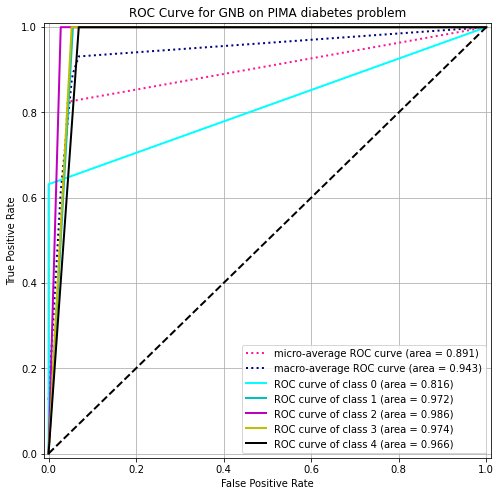

In [27]:
plot_multiple_roc(y_test, np.array(pd.get_dummies(y_pred_gnb)), 'GNB')

<hr>
<hr>

# Summary (Metrics)

## Runtime

In [28]:
print('Neural Network training time\t: {}s'.format(nn_time))
print('Gaussian Naive Bayes time\t: {}s'.format(gnb_time))
print('K-nearest Neighbors time\t: {}s'.format(knn_time))

Neural Network training time	: 2.38s
Gaussian Naive Bayes time	: 0.0s
K-nearest Neighbors time	: 0.0s


## Confusion Matrix

In [29]:
print('Neural Network:\n {}'.format(nn_cm))
print('\nGaussian Naive Bayes:\n {}'.format(gnb_cm))
print('\nK-nearest Neighbors:\n {}'.format(knn_cm))

Neural Network:
 [[18  0  0  1  0]
 [ 0  4  0  0  0]
 [ 0  0  4  0  0]
 [ 0  0  0  2  0]
 [ 0  0  0  0 11]]

Gaussian Naive Bayes:
 [[12  2  1  2  2]
 [ 0  4  0  0  0]
 [ 0  0  4  0  0]
 [ 0  0  0  2  0]
 [ 0  0  0  0 11]]

K-nearest Neighbors:
 [[17  1  0  1  0]
 [ 0  4  0  0  0]
 [ 0  0  4  0  0]
 [ 0  0  0  2  0]
 [ 1  0  0  0 10]]


## Accuracy score

In [30]:
print('Neural Network \t\t: {}'.format(nn_acc))
print('Gaussian Naive Bayes \t: {}'.format(gnb_acc))
print('K-nearest Neighbors \t: {}'.format(knn_acc))

Neural Network 		: 0.975
Gaussian Naive Bayes 	: 0.825
K-nearest Neighbors 	: 0.925
